In [67]:

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import glob


In [68]:
# Load Normal and Anomalous Data
normal_features_path = r'C:\My_Stuff\College\Capstone Project\CAPSTONE\Capstone_2\VideoAnomalyDetection\extracted_features_csv\normal\*.csv'
anomalous_features_path = r'C:\My_Stuff\College\Capstone Project\CAPSTONE\Capstone_2\VideoAnomalyDetection\extracted_features_csv\anomalous\*.csv'

# Load normal features
normal_files = glob.glob(normal_features_path)
normal_dfs = [pd.read_csv(file) for file in normal_files]
normal_data = pd.concat(normal_dfs, ignore_index=True)

# Load anomalous features
anomalous_files = glob.glob(anomalous_features_path)
anomalous_dfs = [pd.read_csv(file) for file in anomalous_files]
anomalous_data = pd.concat(anomalous_dfs, ignore_index=True)

# Combine data and create labels
normal_data['label'] = 0
anomalous_data['label'] = 1
df = pd.concat([normal_data, anomalous_data], ignore_index=True)

# Display the column names
print(df.columns)

Index(['Frame Number', 'Number of Objects', 'Spatial Density',
       'Class Distribution', 'Mean Velocity', 'Max Velocity',
       'Variance in Velocity', 'Mean Acceleration', 'Max Acceleration',
       'Variance in Acceleration', 'Mean Direction', 'Direction Variance',
       'Mean Displacement', 'Angle Variance', 'Interaction Count', 'Mean IoU',
       'Spatial Density.1', 'label'],
      dtype='object')


In [69]:
# Preprocess Data: Calculate the changes (deltas) between consecutive frames for each numerical feature
# Select only numerical columns, excluding 'label'
numerical_cols = df.select_dtypes(include=[np.number]).drop(columns=['label']).columns

# Calculate the differences for only the numerical features
df_diff = df[numerical_cols].diff().fillna(0)

# Separate features (X) and labels (y)
X = df_diff
y = df['label']

In [70]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)



In [72]:
# Define LightGBM parameters
params = {
    'objective': 'binary',  # Binary classification
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}


In [73]:
# Train the LightGBM classifier
num_round = 100  # Number of boosting rounds
bst = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[train_data, test_data],  # Include both training and testing data for validation
    valid_names=['train', 'valid'],       # Names for the datasets
    callbacks=[lgb.early_stopping(stopping_rounds=10)]  # Early stopping callback
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9962, number of negative: 17463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3380
[LightGBM] [Info] Number of data points in the train set: 27425, number of used features: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363245 -> initscore=-0.561307
[LightGBM] [Info] Start training from score -0.561307
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.552917	valid's binary_logloss: 0.581506


In [74]:
# Save the trained LightGBM model
model_save_path = r'C:\My_Stuff\College\Capstone Project\CAPSTONE\Capstone_2\VideoAnomalyDetection\LightBgm-model\lightgbm_model.txt'
bst.save_model(model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to C:\My_Stuff\College\Capstone Project\CAPSTONE\Capstone_2\VideoAnomalyDetection\LightBgm-model\lightgbm_model.txt


In [75]:
# Evaluate the model on the test set
y_pred = bst.predict(X_test)
y_pred_label = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))

Accuracy: 0.6911185649701035
              precision    recall  f1-score   support

           0       0.71      0.89      0.79      4397
           1       0.63      0.34      0.44      2460

    accuracy                           0.69      6857
   macro avg       0.67      0.61      0.61      6857
weighted avg       0.68      0.69      0.66      6857



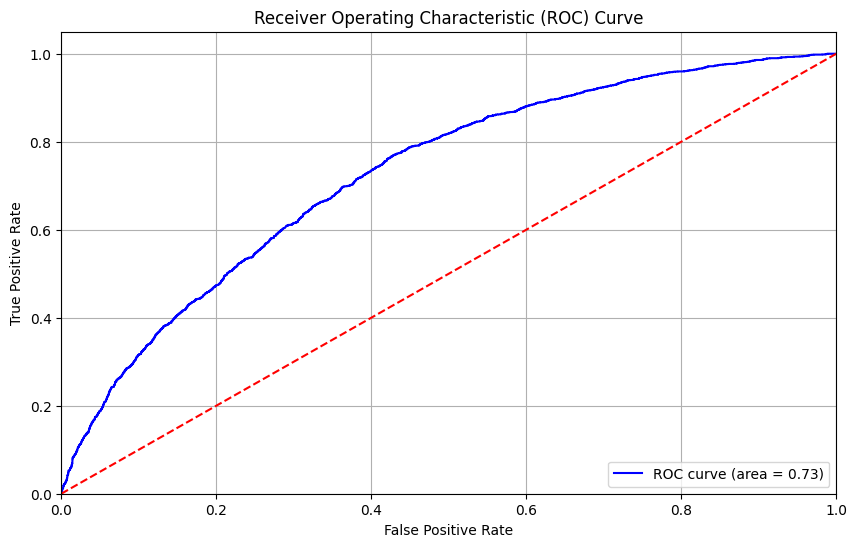

In [76]:
# Plot ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()